## Advanced Lane Finding

### Imports

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# to read images named as name1, name2, ...
import glob
%matplotlib inline

### Functions Library

In [2]:
# Gaussian blur the image with input kernel size
def gaussian_blur(img, kernel_size):
    # Applies a Gaussian Noise kernel
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# unwarp the corners of the chessboard image
def cornersUnwarp(img, nx, ny, mtx, dist, corners):
    # Pass in your image into this function
    # Write code to do the following steps
    img_size = (img.shape[1], img.shape[0])
    # extra space for including more of the image
    xe = (corners[1][0][0] - corners[0][0][0])/2
    ye = (corners[nx][0][1] - corners[0][0][1])/2
    # source points
    src = np.float32((corners[0][0] - [xe, ye],
        corners[nx-1][0] + [xe, -ye],
        corners[(nx*ny)-1][0] + [xe, ye],
        corners[nx*(ny-1)][0] - [xe, -ye]))
    tl, tr, br, bl = src
    # destination points
    dst = np.float32([[0, 0],
        [img_size[0] - 1, 0],
        [img_size[0] - 1, img_size[1] - 1],
        [0, img_size[1] - 1]])
    # get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # warp image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

# calibrate the camera and return the camera marix to be used later
def camCalibrate(img_name_list, nx, ny):
    for name in img_name_list:
        img = cv2.imread(name)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)        # Convert to grayscale
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)    # Find the chessboard corners
        # If found, store imagepoint and object point data and draw corners
        if ret == True:
            objPoints.append(np.copy(objp))
            imgPoints.append(corners)
            #images.append(img)
    # get calibration parameters
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, gray.shape[::-1],
                                                           None, None)
    return mtx, dist
    
# get calibrated image
def getCaliberatedImage(image, mtx, dist):
    undist = np.zeros_like(image)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    #undist[:,:,1] = cv2.undistort(image[:,:,1], mtx, dist, None, mtx)
    #undist[:,:,2] = cv2.undistort(image[:,:,2], mtx, dist, None, mtx)
    return undist

# subtract median from image
def getMedianLessImage(img):
    #hsv = cv2.cvtColor(rgbimg, cv2.COLOR_RGB2HSV)
    t_img = np.zeros_like(img)
    t1 = img[:,:,0] - np.median(img[:,:, 0])*1.2
    t2 = img[:,:,1] - np.median(img[:,:, 1])*1.2
    t3 = img[:,:,2] - np.median(img[:,:, 2])*1.2
    t1[t1<0] = 0
    t2[t2<0] = 0
    t3[t3<0] = 0
    t_img[:,:,0], t_img[:,:,1], t_img[:,:,2] = t1, t2, t3
    return t_img

# get mask for the image which would be used to get the lane lines
def getColorMaskedImage(rgbimg, median_less = True):
    # get mask structures as per input image dimensions
    masked_img = np.zeros_like(rgbimg[:,:,0])
    t_img = rgbimg
    base_thresh = 40
    d_factor = 10
    generic_mean = 40
    if not median_less:
        base_thresh = 220
        d_factor = 15
        generic_mean = 80
    else:
        t_img = getMedianLessImage(rgbimg)
    # Prepare thresholds
    rm = base_thresh - (generic_mean - np.median(t_img[:,:, 0])) / d_factor
    gm = base_thresh - (generic_mean - np.median(t_img[:,:, 1])) / d_factor
    bm = base_thresh - (generic_mean - np.median(t_img[:,:, 2])) / d_factor
    #print(rm, gm, bm)
    masked_img[(t_img[:,:,0]>=rm) | (t_img[:,:,1]>=gm) | (t_img[:,:,2]>=bm)] = 1
    return masked_img

# get gradient in x or y direction of magnitude of te gradient, axis can be 'x', 'y' or 'm'
def getGradient(gray, axis='x', sobel_kernel=3):
    grad = None
    if axis == 'x':
        grad = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif axis == 'y':
        grad = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    else:
        gradx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
        grady = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        grad = np.sqrt((gradx ** 2) + (grady ** 2))
        
    grad = np.uint8(255*grad/np.max(grad))
    return grad

# get threshold in specified direction range
def dirThreshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # gradient in x and y separately
    abs_sobelx = getGradient(gray, 'x', 3)
    abs_sobely = getGradient(gray, 'y', 3)
    # calculate the direction of the gradient 
    sobel_thresh = np.arctan2(abs_sobely, abs_sobelx)
    # binary mask where direction thresholds are met
    binary_output = np.zeros_like(abs_sobelx)
    binary_output[(sobel_thresh >= thresh[0]) & (sobel_thresh <= thresh[1])] = 1
    return binary_output


def prepareImageMask(bgrimg, color_mask, median_less = True):
    rgbimg = cv2.cvtColor(bgrimg, cv2.COLOR_BGR2RGB)
    hlsimg = cv2.cvtColor(bgrimg, cv2.COLOR_BGR2HLS)
    if color_mask:
        return getColorMaskedImage(rgbimg, median_less = False)
    # RGB color difference mask for detecting yellow color
    o1binary = np.zeros_like(rgbimg[:,:,1])
    o1binary[(abs(rgbimg[:,:,0]-rgbimg[:,:,1]) <=25) & (abs(rgbimg[:,:,0]-rgbimg[:,:,2]) >=40)] = 1
    # HLS mask for yellow and white color
    binary = np.zeros_like( hlsimg[:,:,0])
    binary[(((hlsimg[:,:,0] >= 18)  & (hlsimg[:,:,0] <= 22))) & (o1binary == 1)] = 1
    
    obinary = np.zeros_like( hlsimg[:,:,0])
    obinary[(binary == 1) | (hlsimg[:,:,1] >180)] = 1
    return obinary

# find points for use in perspective transform from the image
def getSourceDestPoints(image_2d_mask):
    # two slots in image
    w = image_2d_mask.shape[1]
    h = image_2d_mask.shape[0]
    
    src = np.float32(([(w*2/5)+33, h*0.65],
    [(w*3/5), h*0.65],
    [w, h],
    [0, h]))
    '''src = np.float32(([(w/2)-100, h*0.65],
    [(w/2)+100, h*0.65],
    [w, h],
    [0, h]))'''
    dst = np.float32([[0, 0],
        [w, 0],
        [w, h],
        [0, h]])

    return src, dst

# Find the position of peaks from the image slice of size image height x slf (0.15 <= slf <= 0.85)
def getHistogramPeakPositions(warped_image, min_y, max_y):
    histogram = np.sum(warped_image[min_y:max_y,:], axis=0)
    #plt.plot(histogram)
    #plt.show()
    left_hist = histogram[:len(histogram)//2]
    right_hist = histogram[len(histogram)//2:]
    sl = np.argmax(left_hist)
    sr = np.argmax(right_hist) + len(histogram)//2
    return sl, sr


### Calibrate the Camera

In [3]:
# prepare object points
# number of inside corners in x and y
nx, ny = 9, 6
# Store Object points and image points from all the images
objPoints = []  # 3D points in real world space
imgPoints = []  # 3D points in image place

# Prepare object points like (0,0,0), (1,0,0), (2,0,0)...(8,5,0)
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2) # a list of x, y coordinates

# Make a list of calibration images
image_names = glob.glob('./camera_cal/calibration*.jpg')
rows = len(image_names)

cam_mtx = None
cam_dist = None

# read all the images and prepare camera matrix
cam_mtx, cam_dist = camCalibrate(image_names, nx, ny)

### Calibration testing

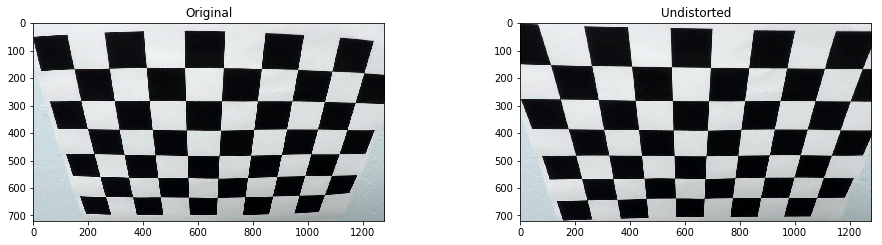

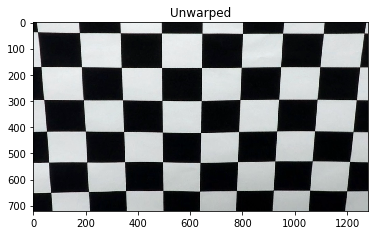

In [4]:
# test camera matrix on a chessboard image
img = cv2.imread(image_names[11])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)        # Convert to grayscale
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)    # Find the chessboard corners
undist = cv2.undistort(img, cam_mtx, cam_dist, None, cam_mtx)
warped_image = cornersUnwarp(undist, nx, ny, cam_mtx, cam_dist, corners)

fig1 = plt.figure(figsize=(16, 8))
fig1.add_subplot(2, 2, 1)
plt.title("Original")
plt.imshow(img)

fig1.add_subplot(2, 2, 2)
plt.title("Undistorted")
plt.imshow(undist)
plt.show()

fig1.add_subplot(2, 2, 3)
plt.title("Unwarped")
plt.imshow(warped_image)
plt.show()

### Test with Test images

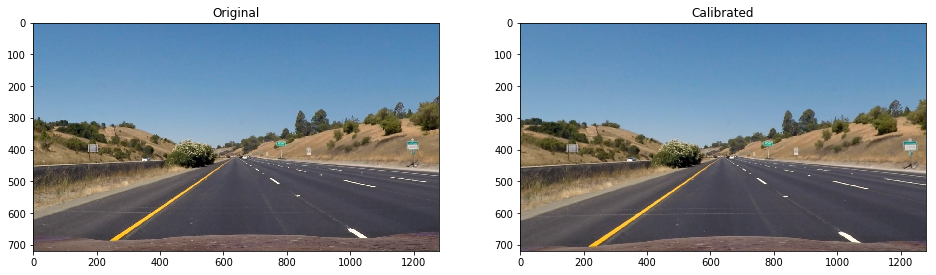

In [5]:
t_img = cv2.imread("./test_images/road22.jpg")
img = cv2.cvtColor(t_img, cv2.COLOR_BGR2RGB)

fig1 = plt.figure(figsize=(16, 8))
fig1.add_subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img)

img = getCaliberatedImage(img, cam_mtx, cam_dist)
fig1.add_subplot(1, 2, 2)
plt.title("Calibrated")
plt.imshow(img)
plt.show()

### Apply Thresholds to Image

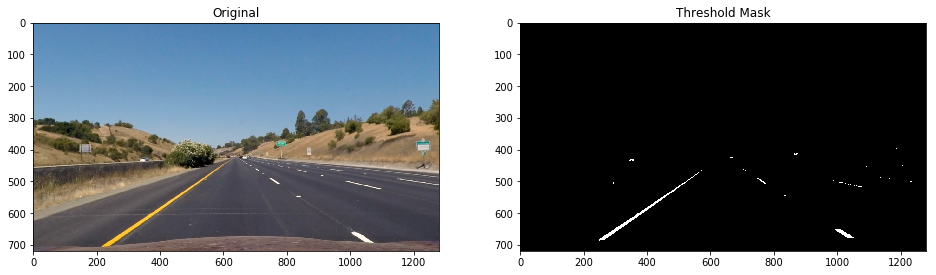

In [6]:
# Apply color thresholds
cmimg = prepareImageMask(t_img, True)
cmimg = gaussian_blur(cmimg, 5)
cmimg[cmimg != 1] = 0
fig1 = plt.figure(figsize=(16, 8))
fig1.add_subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img, cmap="gray")

fig1.add_subplot(1, 2, 2)
plt.title("Threshold Mask")
plt.imshow(cmimg, cmap="gray")
plt.show()

### Transform the Perspective

[[ 545.  468.]
 [ 768.  468.]
 [1280.  720.]
 [   0.  720.]] [[   0.    0.]
 [1280.    0.]
 [1280.  720.]
 [   0.  720.]]


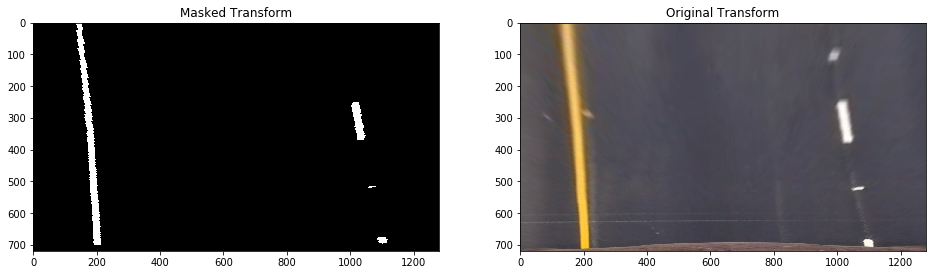

In [7]:
img_size = (cmimg.shape[1], cmimg.shape[0])
src, dst = getSourceDestPoints(cmimg)
print(src, dst)
M = cv2.getPerspectiveTransform(src, dst)
rM = cv2.getPerspectiveTransform(dst, src)

warped = cv2.warpPerspective(cmimg, M, img_size, flags=cv2.INTER_LINEAR)
fig1 = plt.figure(figsize=(16,8))
fig1.add_subplot(1, 2, 1)
plt.title("Masked Transform")
plt.imshow(warped, cmap="gray")

warped_o = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
fig1.add_subplot(1, 2, 2)
plt.title("Original Transform")
plt.imshow(warped_o)
plt.show()

### Sliding window search 

In [8]:
#### Perform a sliding window search for the lane lines ####

win_n = 15    # number of vertical segments
win_h = warped.shape[0] // win_n    # height of each segment
left_points = []   # [(x1, y1), (x2, y2), ...] points for left lane line
right_points = []  # points depicting right lane line

# points found for last window

out_img = np.dstack((warped, warped, warped))*255

clx, crx = getHistogramPeakPositions(warped, warped_image.shape[0]//3, warped.shape[0]+1)
print(clx, crx)

non_zero = warped.nonzero()
non_zero_y = np.array(non_zero[0])
non_zero_x = np.array(non_zero[1])

win_w = 150
exp_points = 50

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

for cwin_n in range(win_n):
    win_min_y = warped.shape[0]*(win_n - cwin_n - 1)//win_n
    win_max_y = win_min_y + win_h
    if win_min_y < 0:
        win_min_y = 0
    #nlx, nrx = 0, 0
    # rectangle coordinates
    left_x_mn = clx - win_w
    left_x_mx = clx + win_w
    right_x_mn = crx - win_w
    right_x_mx = crx + win_w
    # Draw the windows on the visualization image
    cv2.rectangle(out_img, (left_x_mn, win_min_y), (left_x_mx, win_max_y), (0,255,0), 2)
    cv2.rectangle(out_img, (right_x_mn, win_min_y), (right_x_mx, win_max_y), (0,255,0), 2)
    # Identify the nonzero pixels in x and y within the window
    hot_left_inds = ((non_zero_x >= left_x_mn)
                      & (non_zero_x < left_x_mx)
                      & (non_zero_y >= win_min_y)
                      & (non_zero_y < win_max_y)).nonzero()[0]
    hot_right_inds = ((right_x_mn <= non_zero_x)
                      & (right_x_mx > non_zero_x)
                      & (win_min_y <= non_zero_y)
                      & (win_max_y > non_zero_y)).nonzero()[0]
    
    # If you found > exp_points pixels, recenter next window on their mean position
    #f = False
    #clx, crx = getHistogramPeakPositions(warped, warped_image.shape[0]//2, warped.shape[0]+1)
    if len(hot_left_inds) > exp_points:
        clx = np.int(np.mean(non_zero_x[hot_left_inds]))
    
    if len(hot_right_inds) > exp_points:        
        crx = np.int(np.mean(non_zero_x[hot_right_inds]))
    
    left_lane_inds.append(hot_left_inds)
    right_lane_inds.append(hot_right_inds)

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = non_zero_x[left_lane_inds]
lefty = non_zero_y[left_lane_inds] 
rightx = non_zero_x[right_lane_inds]
righty = non_zero_y[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

190 1024


### Draw line on image

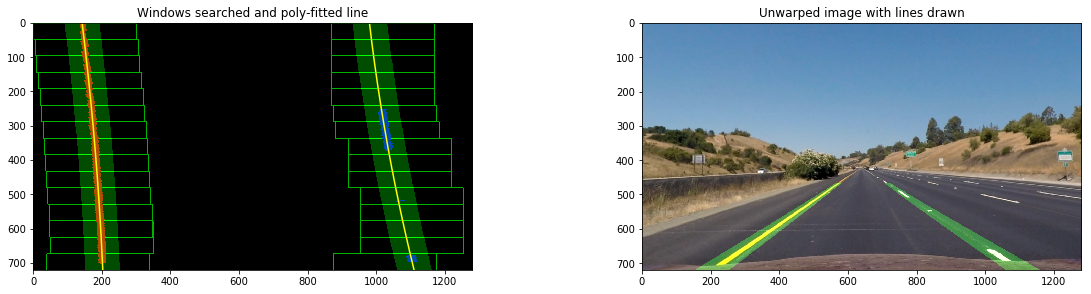

In [9]:
#### Plot a line by using the derived polynomial coefficients ####
margin = 50
# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


# Create an image to draw on and an image to show the selection window
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[non_zero_y[left_lane_inds], non_zero_x[left_lane_inds]] = [255, 0, 0]
out_img[non_zero_y[right_lane_inds], non_zero_x[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 0.7, window_img, 0.3, 0)

fig1 = plt.figure(figsize=(20,10))
fig1.add_subplot(2, 2, 1)
plt.title("Windows searched and poly-fitted line")
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.imshow(result)

# unwarp the image to superimpose on original image
unwarped = cv2.warpPerspective(window_img, rM, img_size, flags=cv2.INTER_LINEAR)
result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
fig1.add_subplot(2, 2, 2)
plt.title("Unwarped image with lines drawn")
plt.imshow(result)
plt.show()

### Radius of Curvature

In [10]:
# returns text containing radius of curvature
# input must be left and right fit x and y values
def getRadius(left_fitx, right_fitx, ploty):
    rad_curve = None
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    #left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    #right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    rad_curve = ((left_curverad + right_curverad)/2).round(2)
    return rad_curve

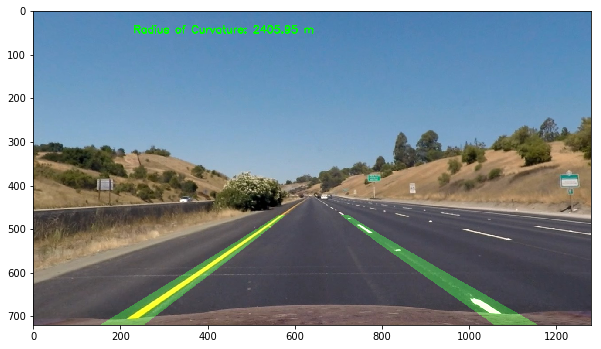

In [11]:
#print(getRadius(left_fitx, right_fitx, ploty))
xm_per_pix = 3.7/700 # meters per pixel in x dimension
result_op = np.copy(result)
rad_curve = getRadius(left_fitx, right_fitx, ploty)
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(result_op, "Radius of Curvature: "+str(rad_curve)+" m", (230, 50), font, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
plt.figure(figsize=(10,10))
plt.imshow(result_op)
plt.show()

### Get Vehicle position

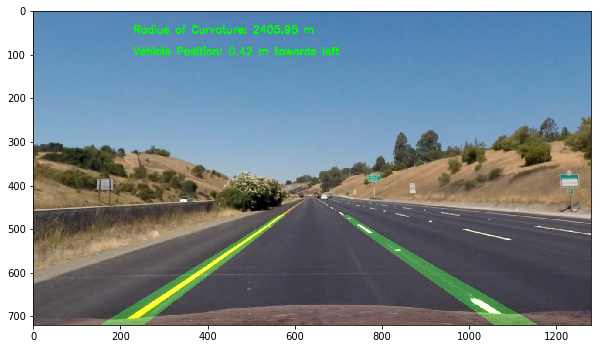

In [12]:
# Calculate vehicle position
vehicle_pos = (left_fitx[0]+right_fitx[0])/2
pos = "towards left"
if img_size[0]//2 < vehicle_pos:
    pos = "towards right"
vehicle_pos = (xm_per_pix*(abs(vehicle_pos-img_size[0]//2))).round(2)
cv2.putText(result_op, "Vehicle Position: "+str(vehicle_pos)+" m "+pos, (230, 100), font, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
plt.figure(figsize=(10,10))
plt.imshow(result_op)
plt.show()

### Video Pipeline

In [13]:
from moviepy.editor import VideoFileClip, concatenate_videoclips
from IPython.display import HTML


init_f = True  # after value exceeds 10, do not use init_process for processing
p_cnt = 0
M = None
rM = None
plx, prx = [], []
left_fit = None
right_fit = None

def init_process(ip_img, color_mask):
    global cam_mtx, cam_dist, M, rM, plx, prx, left_fit, right_fit
    # calibrate image
    nimg = getCaliberatedImage(ip_img, cam_mtx, cam_dist)
    # apply thresholds to bgr image
    cmimg = prepareImageMask(cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR), color_mask)
    # transform the perspective
    img_size = (cmimg.shape[1], cmimg.shape[0])
    src, dst = getSourceDestPoints(cmimg)
    M = cv2.getPerspectiveTransform(src, dst)
    rM = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(cmimg, M, img_size, flags=cv2.INTER_LINEAR)
    
    # Sliding window search
    win_n = 15    # number of vertical segments
    win_h = warped.shape[0] // win_n    # height of each segment
    left_points = []   # [(x1, y1), (x2, y2), ...] points for left lane line
    right_points = []  # points depicting right lane line

    # points found for last window

    out_img = np.dstack((warped, warped, warped))*255

    clx, crx = getHistogramPeakPositions(warped, warped_image.shape[0]//3, warped.shape[0]+1)
    pxln = len(prx)
    lxs, rxs = 0, 0
    if pxln != 0:
        dfact = ((pxln+1)*(pxln+2))//2
        for i in range(pxln):
            lxs += (i+1)*plx[i]
            rxs += (i+1)*prx[i]
        lxs += (pxln+1)*clx
        rxs += (pxln+1)*crx
        clx = lxs//dfact
        crx = rxs//dfact
    non_zero = warped.nonzero()
    non_zero_y = np.array(non_zero[0])
    non_zero_x = np.array(non_zero[1])

    win_w = 100
    exp_points = 40

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    for cwin_n in range(win_n):
        win_min_y = warped.shape[0]*(win_n - cwin_n - 1)//win_n
        win_max_y = win_min_y + win_h
        if win_min_y < 0:
            win_min_y = 0
        #nlx, nrx = 0, 0
        # rectangle coordinates
        left_x_mn = clx - win_w
        left_x_mx = clx + win_w
        right_x_mn = crx - win_w
        right_x_mx = crx + win_w
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (left_x_mn, win_min_y), (left_x_mx, win_max_y), (0,255,0), 2)
        cv2.rectangle(out_img, (right_x_mn, win_min_y), (right_x_mx, win_max_y), (0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        hot_left_inds = ((non_zero_x >= left_x_mn)
                          & (non_zero_x < left_x_mx)
                          & (non_zero_y >= win_min_y)
                          & (non_zero_y < win_max_y)).nonzero()[0]
        hot_right_inds = ((right_x_mn <= non_zero_x)
                          & (right_x_mx > non_zero_x)
                          & (win_min_y <= non_zero_y)
                          & (win_max_y > non_zero_y)).nonzero()[0]

        # If you found > exp_points pixels, recenter next window on their mean position
        #f = False
        #clx, crx = getHistogramPeakPositions(warped, warped_image.shape[0]//2, warped.shape[0]+1)
        if len(hot_left_inds) > exp_points:
            clx = np.int(np.mean(non_zero_x[hot_left_inds]))

        if len(hot_right_inds) > exp_points:        
            crx = np.int(np.mean(non_zero_x[hot_right_inds]))
        
        if cwin_n == 0:
            plx.append(clx)
            prx.append(crx)
            if len(plx) >= 10:
                plx.pop(0)
                prx.pop(0)
        left_lane_inds.append(hot_left_inds)
        right_lane_inds.append(hot_right_inds)

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = non_zero_x[left_lane_inds]
    lefty = non_zero_y[left_lane_inds] 
    rightx = non_zero_x[right_lane_inds]
    righty = non_zero_y[right_lane_inds] 

    # Fit a second order polynomial to each
    if len(leftx) != 0 and len(rightx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

    return nimg, warped


def process_image(ip_img):
    global cam_mtx, cam_dist, p_cnt, init_f, M, rM, plx, prx, left_fit, right_fit, color_mask
    img_size = (ip_img.shape[1], ip_img.shape[0])
    p_cnt = 0
    if init_f:
        nimg, warped = init_process(ip_img, color_mask)
        p_cnt+=1
        if p_cnt > 20:
            init_f = False
    else:
        #init_f = True
        # calibrate image
        nimg = getCaliberatedImage(ip_img, cam_mtx, cam_dist)
        # apply thresholds to bgr image
        cmimg = prepareImageMask(cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR), color_mask)
        # transform the perspective
        warped = cv2.warpPerspective(cmimg, M, img_size, flags=cv2.INTER_LINEAR)
    
    # Sliding window search is already done
    out_img = np.dstack((warped, warped, warped))*255

    non_zero = warped.nonzero()
    non_zero_y = np.array(non_zero[0])
    non_zero_x = np.array(non_zero[1])
    ###################################
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    margin = 25
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    #print(p_cnt)
    if not init_f:
        left_lane_inds = ((non_zero_x > (left_fit[0]*(non_zero_y**2) + left_fit[1]*non_zero_y + 
        left_fit[2] - margin)) & (non_zero_x < (left_fit[0]*(non_zero_y**2) + 
        left_fit[1]*non_zero_y + left_fit[2] + margin))) 

        right_lane_inds = ((non_zero_x > (right_fit[0]*(non_zero_y**2) + right_fit[1]*non_zero_y + 
        right_fit[2] - margin)) & (non_zero_x < (right_fit[0]*(non_zero_y**2) + 
        right_fit[1]*non_zero_y + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = non_zero_x[left_lane_inds]
        lefty = non_zero_y[left_lane_inds] 
        rightx = non_zero_x[right_lane_inds]
        righty = non_zero_y[right_lane_inds]
        # Fit a second order polynomial to each
        if len(leftx) != 0 and len(rightx) != 0:
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
    if left_fit is None or right_fit is None:
        return ip_img
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    #out_img[non_zero_y[left_lane_inds], non_zero_x[left_lane_inds]] = [255, 0, 0]
    #out_img[non_zero_y[right_lane_inds], non_zero_x[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    cmb_arr = np.hstack((left_line_window2, right_line_window1))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_(cmb_arr), (0, 0, 250))
    
    # Overlay lanes in output image
    unwarped = cv2.warpPerspective(window_img, rM, img_size, flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(nimg, 0.7, unwarped, 0.3, 0)
    # show warped mask as well
    out_img = cv2.resize(out_img, (360, 240))
    h1, w1 = result.shape[:2]
    h2, w2 = out_img.shape[:2]
    
    #prepare output image frame
    op = np.zeros((max(h1, h2), w1+w2,3), np.uint8)
    op[:h1, :w1,:3] = result
    op[:h2, w1:w1+w2,:3] = out_img
    
    # get radius of curvature
    rad_curve = getRadius(left_fitx, right_fitx, ploty)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(op, "Radius of Curvature: "+str(rad_curve)+" m", (230, 50), font, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
    # calculate vehicle position
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    vehicle_pos = (left_fitx[0]+right_fitx[0])/2
    pos = "towards left"
    if w1//2 < vehicle_pos:
        pos = "towards right"
    vehicle_pos = (xm_per_pix*(abs(vehicle_pos-(w1//2)))).round(2)
    cv2.putText(op, "Vehicle Position: "+str(vehicle_pos)+" m "+pos, (230, 100), font, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
    return op

### Test on project video

In [14]:
init_f = True  # after value exceeds 10, do not use init_process for processing
p_cnt = 0
M = None
rM = None
plx, prx = [], []
left_fit = None
right_fit = None
color_mask = True
output_vid = './output_videos/project_video.mp4'
in_clip = VideoFileClip("project_video.mp4")

output_clip = in_clip.fl_image(process_image)
%time output_clip.write_videofile(output_vid, audio=False)

[MoviePy] >>>> Building video ./output_videos/project_video.mp4
[MoviePy] Writing video ./output_videos/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:26<00:00,  7.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video.mp4 

Wall time: 3min 28s


In [15]:
HTML("""
<video style='width:960px;height:540px' controls>
  <source src="{0}">
</video>
""".format('./output_videos/project_video.mp4'))

### Test on challenge video

In [16]:
init_f = True # after value exceeds 10, do not use init_process for processing
p_cnt = 0
M = None
rM = None
plx, prx = [], []
left_fit = None
right_fit = None
color_mask = False
chl_vid = './output_videos/challenge_video.mp4'
in_clip = VideoFileClip("challenge_video.mp4")

output_clip = in_clip.fl_image(process_image)

%time output_clip.write_videofile(chl_vid, audio=False)

[MoviePy] >>>> Building video ./output_videos/challenge_video.mp4
[MoviePy] Writing video ./output_videos/challenge_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:13<00:00,  7.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/challenge_video.mp4 

Wall time: 1min 15s


In [17]:
HTML("""
<video style='width:960px;height:540px' controls>
  <source src="{0}">
</video>
""".format('./output_videos/challenge_video.mp4'))

### Test on Harder challenge video

In [18]:
init_f = True # after value exceeds 10, do not use init_process for processing
p_cnt = 0
M = None
rM = None
plx, prx = [], []
left_fit = None
right_fit = None
color_mask = True
chl_vid = './output_videos/harder_challenge_video.mp4'
in_clip = VideoFileClip("harder_challenge_video.mp4")

output_clip = in_clip.fl_image(process_image)

%time output_clip.write_videofile(chl_vid, audio=False)

[MoviePy] >>>> Building video ./output_videos/harder_challenge_video.mp4
[MoviePy] Writing video ./output_videos/harder_challenge_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [03:59<00:00,  5.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/harder_challenge_video.mp4 

Wall time: 4min 2s


In [19]:
HTML("""
<video style='width:960px;height:540px' controls>
  <source src="{0}">
</video>
""".format('./output_videos/harder_challenge_video.mp4'))